In [20]:
from sklearn.datasets import load_sample_image

In [21]:
china = load_sample_image("china.jpg")/255

flower = load_sample_image("flower.jpg") / 255

<function matplotlib.pyplot.show(close=None, block=None)>

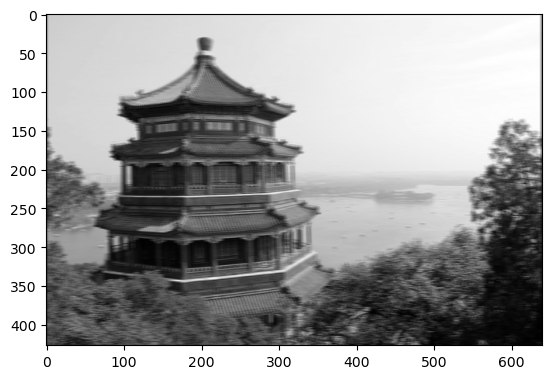

In [27]:
import numpy as np
images = np.array([china, flower])

batch_size, height, width, channels = images.shape

images.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)

filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1

import matplotlib.pyplot as plt

import tensorflow as tf

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray")
plt.show

In [28]:
from tensorflow import keras

In [29]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu")

In [30]:
max_pool = keras.layers.MaxPool2D(pool_size=2)